In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
# Set random seed for numpy
np.random.seed(11)
# Set random seed for pytorch
torch.manual_seed(11)
# Set random seed for pytorch running in GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(11)

In [3]:
# Hyperparameters
num_epochs = 5
batch_size = 100
learning_rate = 0.00001

DATA_PATH = './data'

In [4]:
# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

60000
10000


In [6]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels)
    break

torch.Size([100, 1, 28, 28])
tensor([8, 3, 7, 1, 8, 0, 8, 2, 2, 8, 6, 8, 3, 1, 2, 6, 0, 2, 6, 3, 6, 4, 4, 6,
        8, 8, 0, 9, 1, 1, 5, 7, 9, 6, 2, 5, 4, 9, 9, 3, 6, 7, 0, 5, 4, 6, 7, 9,
        9, 2, 2, 0, 3, 6, 9, 2, 6, 8, 6, 9, 6, 6, 4, 2, 1, 1, 3, 8, 7, 9, 6, 4,
        3, 3, 5, 3, 1, 4, 3, 1, 5, 0, 5, 7, 8, 3, 3, 9, 2, 3, 4, 0, 4, 6, 2, 0,
        8, 8, 7, 1])


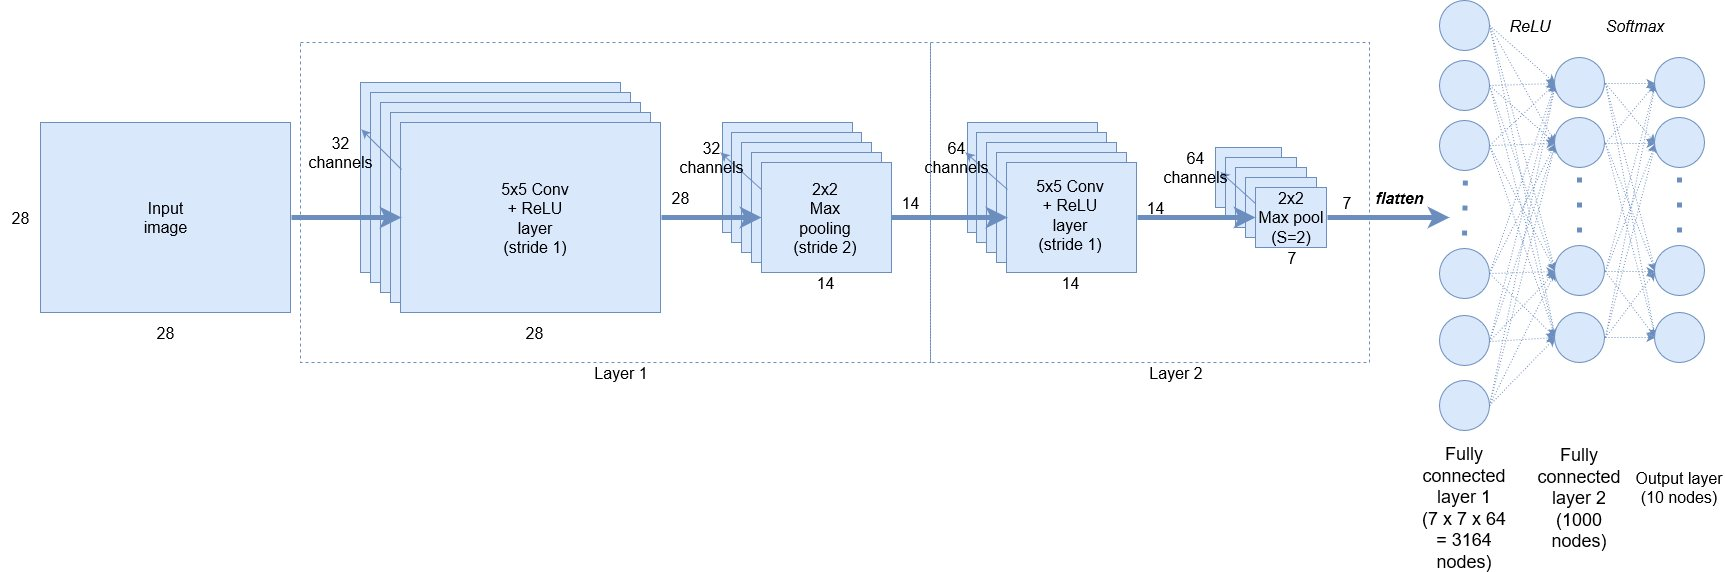

In [7]:
# Layers parameters:
original_image_length = 28
original_image_width = 28
max_pool1_stride = 2
max_pool2_stride = 2
final_image_length = int(original_image_length / max_pool1_stride / max_pool2_stride)
final_image_width = int(original_image_width / max_pool1_stride / max_pool2_stride)
channels_L1 = 32
channels_L2 = 64
nodes_FC1 = 1000
nodes_FC2 = 10 # The number should equal to the number of label types !!!

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, channels_L1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = max_pool1_stride))
        self.layer2 = nn.Sequential(
            nn.Conv2d(channels_L1, channels_L2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = max_pool2_stride))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(final_image_length * final_image_width * channels_L2, nodes_FC1)
        self.fc2 = nn.Linear(nodes_FC1, nodes_FC2)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [9]:
# Choose CPU or GPU
# model = ConvNet() #CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device) #GPU

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Train the model on GPU
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/600], Loss: 1.7311, Accuracy: 65.00%
Epoch [1/5], Step [200/600], Loss: 1.0893, Accuracy: 80.00%
Epoch [1/5], Step [300/600], Loss: 0.6673, Accuracy: 86.00%
Epoch [1/5], Step [400/600], Loss: 0.6719, Accuracy: 84.00%
Epoch [1/5], Step [500/600], Loss: 0.4451, Accuracy: 87.00%
Epoch [1/5], Step [600/600], Loss: 0.4200, Accuracy: 93.00%
Epoch [2/5], Step [100/600], Loss: 0.4636, Accuracy: 91.00%
Epoch [2/5], Step [200/600], Loss: 0.3375, Accuracy: 89.00%
Epoch [2/5], Step [300/600], Loss: 0.3944, Accuracy: 89.00%
Epoch [2/5], Step [400/600], Loss: 0.3426, Accuracy: 93.00%
Epoch [2/5], Step [500/600], Loss: 0.2156, Accuracy: 95.00%
Epoch [2/5], Step [600/600], Loss: 0.2941, Accuracy: 93.00%
Epoch [3/5], Step [100/600], Loss: 0.3742, Accuracy: 91.00%
Epoch [3/5], Step [200/600], Loss: 0.2290, Accuracy: 94.00%
Epoch [3/5], Step [300/600], Loss: 0.1991, Accuracy: 96.00%
Epoch [3/5], Step [400/600], Loss: 0.2047, Accuracy: 95.00%
Epoch [3/5], Step [500/600], Loss: 0.297

In [11]:
# Test the model on GPU
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 96.45 %


In [12]:
"""
# Train the model on CPU

total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
"""

"\n# Train the model on CPU\n\ntotal_step = len(train_loader)\nloss_list = []\nacc_list = []\nfor epoch in range(num_epochs):\n    for i, (images, labels) in enumerate(train_loader):\n        # Run the forward pass\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n        loss_list.append(loss.item())\n\n        # Backprop and perform Adam optimisation\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        # Track the accuracy\n        total = labels.size(0)\n        _, predicted = torch.max(outputs.data, 1)\n        correct = (predicted == labels).sum().item()\n        acc_list.append(correct / total)\n\n        if (i + 1) % 100 == 0:\n            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'\n                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),\n                          (correct / total) * 100))\n"

In [13]:
"""
# Test the model on CPU
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
"""

"\n# Test the model on CPU\nmodel.eval()\nwith torch.no_grad():\n    correct = 0\n    total = 0\n    for images, labels in test_loader:\n        outputs = model(images)\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))\n"